In [1]:
import pyam
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.transforms as mtransforms
import string

from pathlib import Path

<IPython.core.display.Javascript object>

Step 1: Read in the necessary data. We will use two datasets here:
* 101_data.xlsx
* 291_total_mitigation_netzero.xlsx

In [2]:
df = pyam.IamDataFrame(
    Path(
        '../data/101_data.xlsx'
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/101_data.xlsx
pyam.core - INFO: Reading meta indicators


In [3]:
netzero_effort = pd.read_excel(
    Path(
        '../data/201_total_mitigation_netzero.xlsx'
    ),
    index_col=[0,1]
)

Step 2: Filter for the necessary variables.

In [4]:
variables = [
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',#new
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
]

Step 3: Do necessary unit conversions and concatenate data.

In [5]:
panel_a_part_1 = (
    df
    .filter(
        variable=variables[0:2],
    )
)

In [6]:
panel_a_part_2 = (
    df
    .filter(
        variable=variables[2:4]
    )
    .convert_unit(
        current='Gt CO2/yr',
        to='Gt CO2/yr',
        factor=-1
    )
)

In [7]:
panel_a = pyam.concat(
    [
        panel_a_part_1,
        panel_a_part_2
    ]
)

Step 4: Calculate offset from 2020.

In [8]:
panel_a_offset = (
    panel_a
    .filter(
        year=range(2020, 2101)
    )
    .offset(year=2020)
)

In [9]:
panel_a_percent = pyam.IamDataFrame(
    panel_a_offset
    .timeseries()
    .apply(
        lambda x: x * 100/ netzero_effort.loc[x.name[0:2],'netzero'],
        axis=1
    )
)

In [10]:
panel_a_percent.meta = df.meta
panel_a_offset.meta = df.meta

Step 5: Construct a table with the estimates.

In [11]:
table = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        [  
            panel_a_offset.region,
            ['C1', 'C2', 'C3']
        ]
    ),
    columns=pd.MultiIndex.from_product(
        [variables, ['max', 'year_max']]
    )
)

In [12]:
for region in panel_a_percent.region:
    for variable in variables:
        for cat in ['C1', 'C2', 'C3']:
            data = (
                panel_a_percent
                .filter(
                    region=region,
                    variable=variable,
                    Category=cat
                )
                .timeseries()
            )
            m = data.max(axis=1)
            m_y = data.apply(
                lambda x: x[x==x.max()].index.min(),
                axis=1
            )
            table.loc[(region, cat), (variable, 'max')] = f'{m.median().round(2)} [{m.quantile(q=0.25).round(2)}-{m.quantile(q=0.75).round(2)}]'
            table.loc[(region, cat), (variable, 'year_max')] = f'{m_y.median()} [{m_y.quantile(q=0.25)}-{m_y.quantile(q=0.75)}]'

In [13]:
table_formatted = (
    table
    .loc[
        :,
        pd.IndexSlice[
            [
                'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
                'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
                'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land'
            ],
            :
        ]
    ]
    .rename(
        columns={
            'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross':'Gross CO2 reductions',
            'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct':'Land CDR',
            'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land':'Novel CDR'
        }
    )
    #.unstack()
    .swaplevel(axis=0)
    #.swaplevel(i=-2, j=-1, axis=1)
    .sort_index(axis=0)
)

In [14]:
table_formatted

Gross CO2 reductions                           \
                                max                 year_max   
C1 R5ASIA       38.84 [37.74-43.04]   2090.0 [2060.0-2100.0]   
   R5LAM           8.69 [7.57-9.46]   2073.0 [2055.0-2100.0]   
   R5MAF          9.57 [8.79-10.26]   2060.0 [2055.0-2090.0]   
   R5OECD90+EU  24.88 [23.98-26.36]   2100.0 [2062.5-2100.0]   
   R5REF           6.54 [6.26-7.04]   2077.5 [2060.0-2100.0]   
   World        90.39 [86.78-95.68]   2095.0 [2060.0-2100.0]   
C2 R5ASIA       39.66 [37.82-41.07]   2100.0 [2090.0-2100.0]   
   R5LAM           8.76 [8.08-9.62]   2084.5 [2060.0-2100.0]   
   R5MAF         10.04 [8.35-11.25]  2090.0 [2066.25-2092.0]   
   R5OECD90+EU  26.54 [25.18-28.56]   2100.0 [2091.0-2100.0]   
   R5REF           6.69 [5.38-7.23]  2100.0 [2086.25-2100.0]   
   World         93.83 [87.95-96.7]   2100.0 [2090.0-2100.0]   
C3 R5ASIA       37.08 [33.88-39.45]   2100.0 [2080.0-2100.0]   
   R5LAM            8.35 [6.9-8.88]   2080.0 [2060.0-2100.0]   
   R5MAF           8.02 [6.73-9.61]   2080.0 [2070.0-2091.0]   
   R5OECD90+EU  24.64 [22.72-26.12]   2100.0 [2083.5-2100.0]   
   R5REF           6.39 [5.59-7.02]   2100.0 [2071.0-2100.0]   
   World         84.79 [77.3-90.94]   2100.0 [2075.0-2100.0]   

                         Land CDR                           \
                              max                 year_max   
C1 R5ASIA         1.85 [1.18-3.7]  2042.0 [2032.0-2049.75]   
   R5LAM          2.54 [0.9-3.76]  2051.0 [2033.75-2057.0]   
   R5MAF         2.97 [0.51-4.05]   2054.0 [2032.0-2063.0]   
   R5OECD90+EU   0.63 [0.01-1.79]   2050.0 [2021.0-2060.0]   
   R5REF          0.25 [0.0-0.38]  2050.5 [2021.0-2059.75]   
   World        7.78 [6.58-11.12]   2051.0 [2032.0-2056.0]   
C2 R5ASIA         1.56 [0.86-2.0]   2050.0 [2037.0-2071.0]   
   R5LAM          2.2 [1.12-3.67]  2051.0 [2042.0-2061.75]   
   R5MAF         3.05 [0.46-3.96]  2056.5 [2033.25-2072.5]   
   R5OECD90+EU   0.58 [0.11-0.82]   2051.0 [2036.0-2061.0]   
   R5REF         0.29 [0.03-0.35]   2050.5 [2026.0-2081.5]   
   World         7.73 [3.74-9.47]  2051.0 [2037.25-2061.0]   
C3 R5ASIA        1.55 [0.55-3.27]   2047.0 [2032.0-2068.5]   
   R5LAM         2.27 [0.91-3.32]   2060.0 [2035.5-2072.0]   
   R5MAF          1.69 [0.14-3.7]   2058.0 [2028.0-2070.0]   
   R5OECD90+EU   0.73 [0.06-1.12]   2060.0 [2037.0-2073.0]   
   R5REF         0.35 [0.01-0.41]   2051.0 [2031.0-2081.0]   
   World          7.62 [2.89-9.6]   2061.0 [2032.0-2070.0]   

                          Novel CDR                          
                                max                year_max  
C1 R5ASIA          4.61 [3.67-8.38]  2100.0 [2075.0-2100.0]  
   R5LAM           4.67 [2.37-6.14]  2100.0 [2075.0-2100.0]  
   R5MAF           3.42 [3.02-4.67]  2095.0 [2080.0-2100.0]  
   R5OECD90+EU     5.67 [3.04-9.54]  2100.0 [2065.0-2100.0]  
   R5REF           1.41 [0.51-2.17]  2090.0 [2075.0-2100.0]  
   World        18.67 [14.35-32.91]  2100.0 [2070.0-2100.0]  
C2 R5ASIA         8.08 [5.69-10.23]  2100.0 [2100.0-2100.0]  
   R5LAM           6.18 [4.49-7.06]  2100.0 [2100.0-2100.0]  
   R5MAF           5.39 [4.54-7.24]  2100.0 [2100.0-2100.0]  
   R5OECD90+EU    9.21 [7.13-11.78]  2100.0 [2100.0-2100.0]  
   R5REF            1.56 [1.16-2.5]  2100.0 [2100.0-2100.0]  
   World         34.1 [25.36-41.05]  2100.0 [2100.0-2100.0]  
C3 R5ASIA           5.44 [3.6-9.86]  2100.0 [2090.0-2100.0]  
   R5LAM            4.24 [2.5-6.09]  2100.0 [2085.0-2100.0]  
   R5MAF           4.06 [3.02-4.71]  2100.0 [2100.0-2100.0]  
   R5OECD90+EU    6.76 [4.08-10.19]  2100.0 [2080.0-2100.0]  
   R5REF           1.53 [1.06-2.22]  2100.0 [2090.0-2100.0]  
   World         24.14 [15.8-34.14]  2100.0 [2100.0-2100.0]

In [15]:
table_formatted.to_excel(
    Path(
        '../data/202_summary_data.xlsx'
    )
)

Now, we want to calculate the regional net-negative emissions (and compositions) between net zero CO2 and 2100.

In [16]:
netzero_column = 'Year of netzero CO2 emissions (Harm-Infilled) table'

In [17]:
panel_a.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross']

In [18]:
panel_a_cdr_gross_only = (
    panel_a
    .filter(
        variable=[
            'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
            'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
            'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land'
        ]
    )
)

In [19]:
panel_a_cdr_gross_only.aggregate(
    variable='AR6 Reanalysis|OSCARv3.2|Carbon Removal',
    components=[
        'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
        'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land'   
    ],
    append=True
)

Now, we want to loop through each region and calculate the cumulative CDR, cumulative residual emissions, etc.

In [20]:
components_and_meta_names = [
    ('AR6 Reanalysis|OSCARv3.2|Carbon Removal', 'cdr'),
    ('AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct', 'cdr_land'),
    ('AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land', 'cdr_novel'),
    ('AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross', 'gross')
]

In [21]:
cols = ['Category']
for var, name in components_and_meta_names:
    for region in panel_a_cdr_gross_only.region:
        data_ts = (
            panel_a_cdr_gross_only
            .filter(
                variable=var,
                region=region
            )
            .timeseries()
        )
        cumulative = (
            data_ts
            .apply(
                lambda x: pyam.cumulative(
                    x,
                    first_year=panel_a_cdr_gross_only.meta.loc[x.name[0:2], netzero_column],
                    last_year=2100
                ),
                axis=1
            )
        )
        panel_a_cdr_gross_only.set_meta(
            cumulative,
            name=f'{name}_{region}'
        )
        cols.append(f'{name}_{region}')

What do we need (per region)?
* Cumulative gross emissions
* Cumulative removals
* Share of novel removals

We already have the first two, need to compute the last one.

In [22]:
for region in panel_a_cdr_gross_only.region:
    panel_a_cdr_gross_only.meta.loc[:, f'share_novel_{region}'] = (
        panel_a_cdr_gross_only.meta.loc[:, f'cdr_novel_{region}'] * 100
        /
        (
            panel_a_cdr_gross_only.meta.loc[:, f'cdr_novel_{region}']
            +
            panel_a_cdr_gross_only.meta.loc[:, f'cdr_land_{region}']   
        )
    )
    cols.append(f'share_novel_{region}')

Now, we need to know the regional shares of gross emissions and removals as a first step.

In [23]:
panel_a_cdr_gross_only.region

['R5ASIA', 'R5LAM', 'R5MAF', 'R5OECD90+EU', 'R5REF', 'World']

In [24]:
for region in panel_a_cdr_gross_only.region:
    panel_a_cdr_gross_only.meta.loc[:, f'share_gross_{region}'] = (
        panel_a_cdr_gross_only.meta.loc[:, f'gross_{region}'] * 100
        /
        panel_a_cdr_gross_only.meta.loc[:, 'gross_World']
    )

    panel_a_cdr_gross_only.meta.loc[:, f'share_cdr_{region}'] = (
        panel_a_cdr_gross_only.meta.loc[:, f'cdr_{region}'] * 100
        /
        panel_a_cdr_gross_only.meta.loc[:, 'cdr_World']
    )

In [25]:
data = panel_a_cdr_gross_only.meta

In [26]:
categories_and_colors = {
    'C1':'#4dbdab',
    'C2':'#7688ab',
    'C3':'#e74d4d'
}

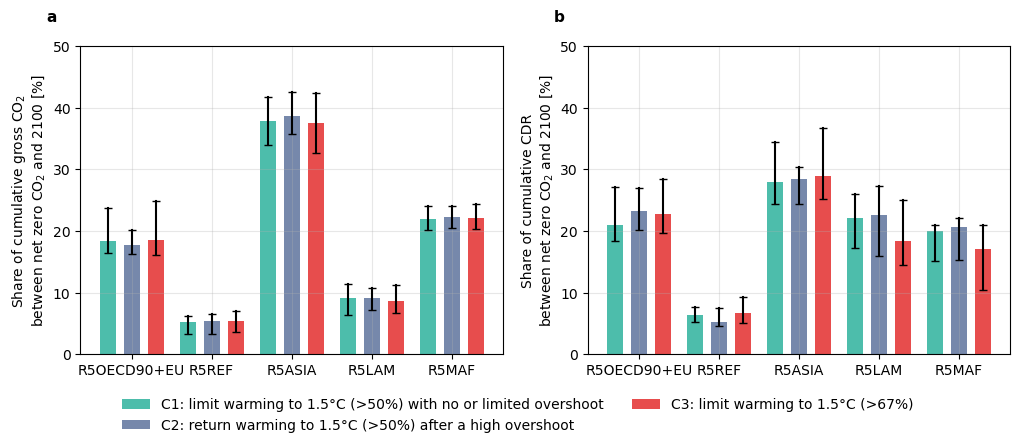

In [27]:
fig, ax = plt.subplots(
    1,
    2,
    figsize=(12, 4)
)

# categories as rows
# gross and cdr as columns
# do this per region
for i, col in enumerate(['share_gross', 'share_cdr']):
    for category in ['C1', 'C2', 'C3']:
        if category=='C1':
            factor = -0.3
        elif category=='C2':
            factor=0
        else:
            factor = 0.3
        for loc, reg in enumerate(['R5OECD90+EU','R5REF','R5ASIA', 'R5LAM', 'R5MAF']):
            location = loc + factor
            data_for_plot = data[data['Category']==category][f'{col}_{reg}']
            ax[i].bar(
                x=location,
                bottom=0,
                height=data_for_plot.median(),
                color=categories_and_colors[category],
                width=0.2
            )

            ax[i].errorbar(
                [location, location],
                [data_for_plot.quantile(q=0.25), data_for_plot.quantile(q=0.75)],
                marker='_',
                color='black'
            )
            ax[i].set_xticks(
                range(5),
                ['R5OECD90+EU','R5REF','R5ASIA', 'R5LAM', 'R5MAF']
            )
            ax[i].grid(alpha=0.3)
            ax[i].set_ylim(0, 50)

ax[0].set_ylabel('Share of cumulative gross CO$_2$\nbetween net zero CO$_2$ and 2100 [%]')
ax[1].set_ylabel('Share of cumulative CDR\nbetween net zero CO$_2$ and 2100 [%]')

# Add a legend common for the plots
custom_legend = [
   # Line2D([0], [0], color='w', label='Panel a'),
    Patch(facecolor=categories_and_colors['C1'], label='C1: limit warming to 1.5°C (>50%) with no or limited overshoot'),
    Patch(facecolor=categories_and_colors['C2'], label='C2: return warming to 1.5°C (>50%) after a high overshoot'),
    Patch(facecolor=categories_and_colors['C3'], label='C3: limit warming to 1.5°C (>67%)'),
]
ax[1].legend(handles=custom_legend, bbox_to_anchor=(0.8, -0.1), ncol=2, framealpha=0.0)
# Add the usual labels
for n, a in enumerate(ax):
    a.text(-0.08, 1.08, string.ascii_lowercase[n], transform=a.transAxes, 
            size=11, weight='bold')

In [28]:
fig.savefig(
    Path('figures/SI_fig2.png'),
    dpi=600,
    bbox_inches='tight'
)